In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import ghibtools as gh
import xarray as xr
import matplotlib.pyplot as plt
from params import subject_keys, odeurs, blocs, count_trials, eeg_chans, run_keys
from coherence import coherence_job, coherence_at_resp_job
from bibliotheque import get_pos, init_nan_da, get_odor_from_session
from epoching import epoch_eeg_job , epoch_bio_job 
import mne
import os

In [2]:
concat = []
for run_key in run_keys:
    concat.append(coherence_at_resp_job.get(run_key).to_dataframe())
coherence = pd.concat(concat)

In [3]:
coherence

,bloc,odor,session,chan,participant,trial,fmax_resp,max_resp,max_coherence
dim_0,,,,,,,,,
0,Free,odor_-,ses02,Fp1,P01,1,0.2125,293.713670,0.044621
1,Free,odor_-,ses02,Fz,P01,1,0.2125,293.713670,0.254964
2,Free,odor_-,ses02,F3,P01,1,0.2125,293.713670,0.285161
3,Free,odor_-,ses02,F7,P01,1,0.2125,293.713670,0.042170
4,Free,odor_-,ses02,FT9,P01,1,0.2125,293.713670,0.149900
...,...,...,...,...,...,...,...,...,...
336,Fast,odor_+,ses04,FC6,P31,3,0.4000,4500.071955,0.915180
337,Fast,odor_+,ses04,FC2,P31,3,0.4000,4500.071955,0.876492
338,Fast,odor_+,ses04,F4,P31,3,0.4000,4500.071955,0.846298


/tmp/ipykernel_2746486/3824715237.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(coherence.corr(), cmap = 'seismic', vmin = -1 , vmax = 1 , annot = True)


<AxesSubplot: >

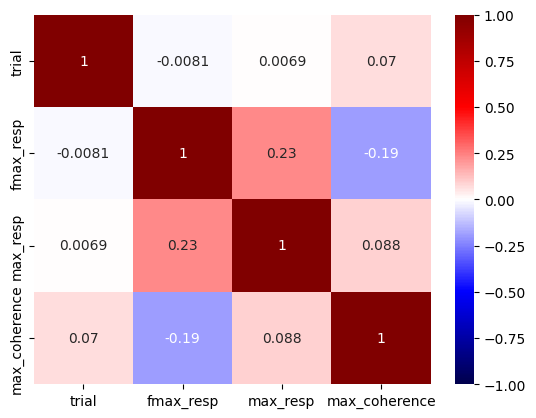

In [4]:
sns.heatmap(coherence.corr(), cmap = 'seismic', vmin = -1 , vmax = 1 , annot = True)

<AxesSubplot: xlabel='bloc', ylabel='fmax_resp'>

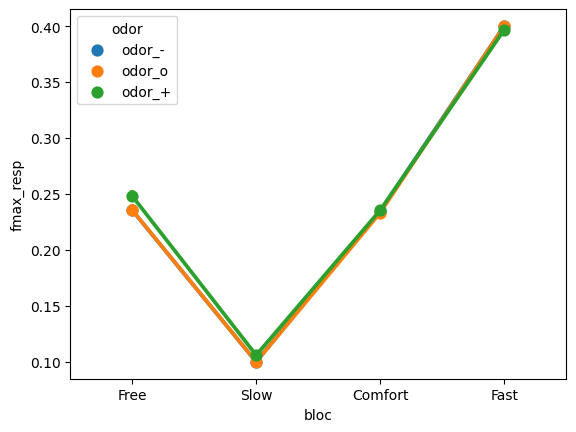

In [5]:
sns.pointplot(data = coherence, x = 'bloc', y = 'fmax_resp', hue = 'odor')

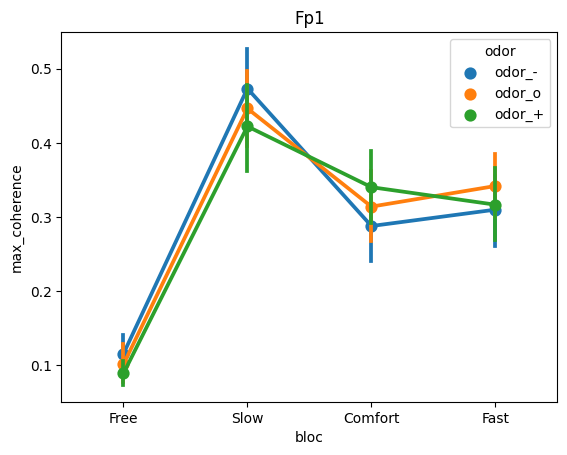

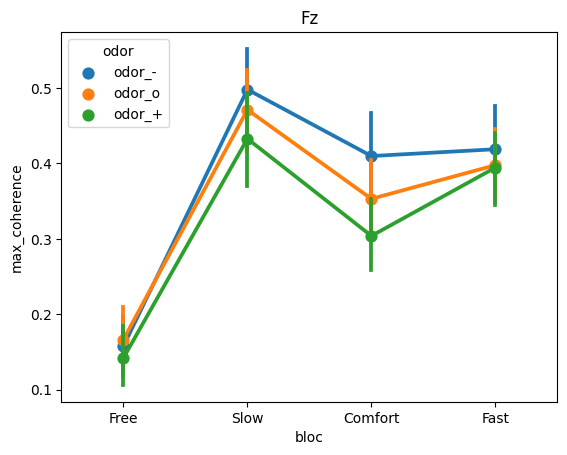

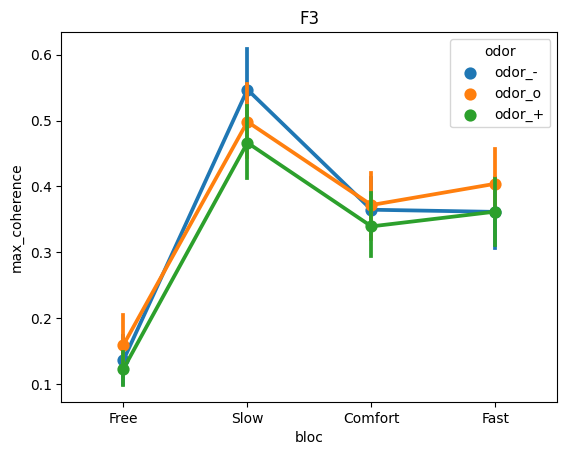

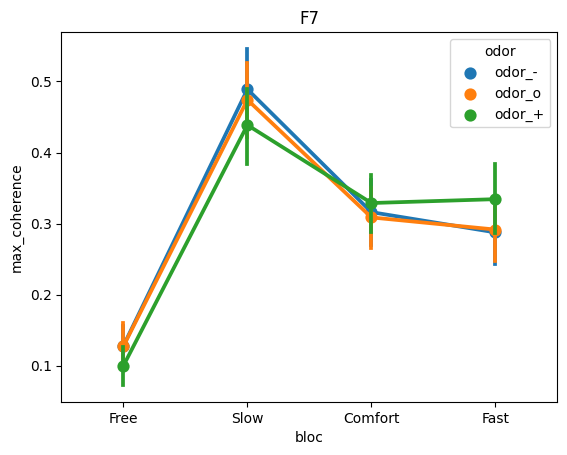

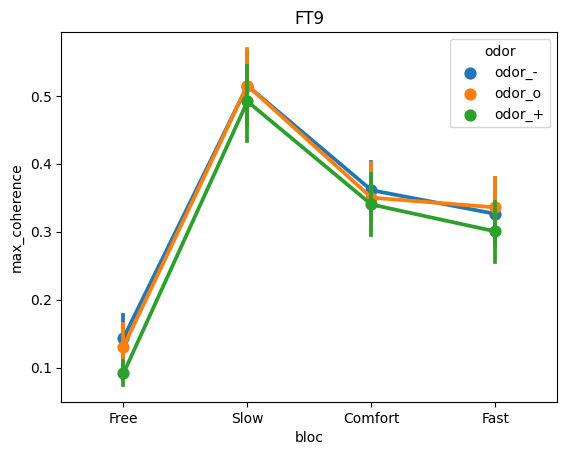

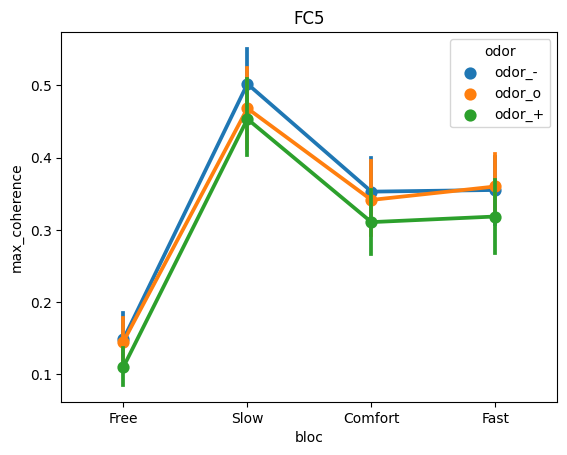

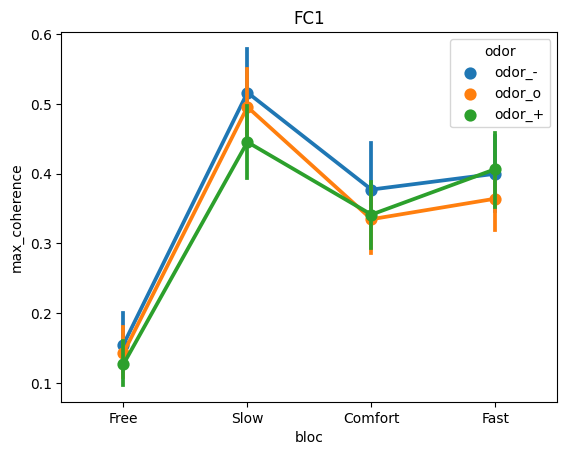

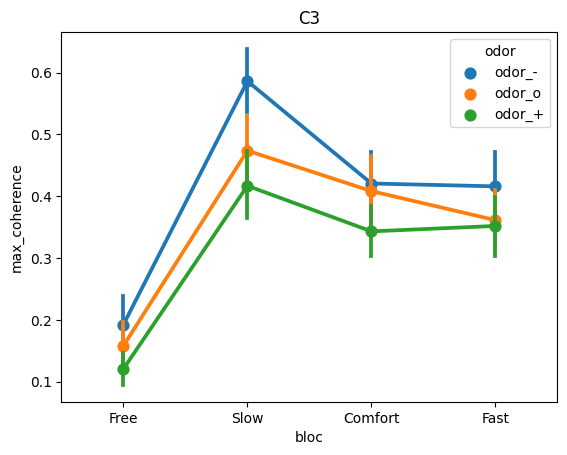

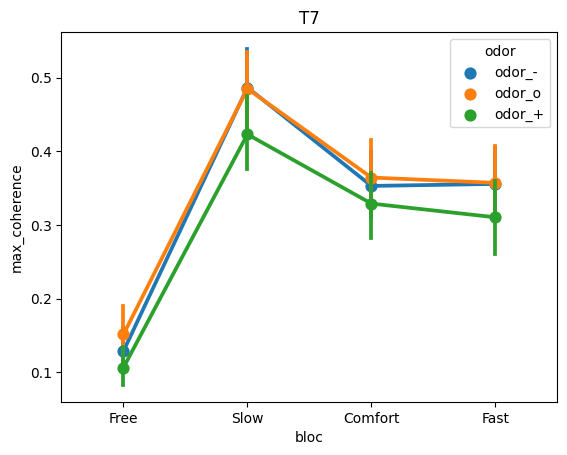

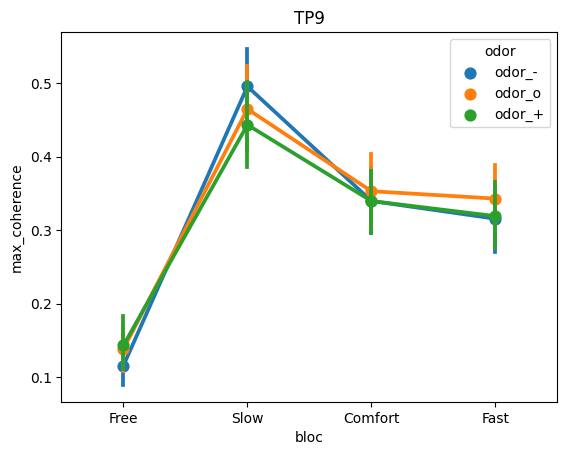

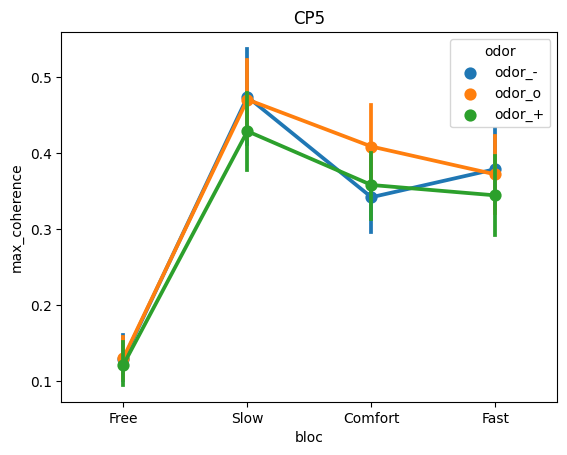

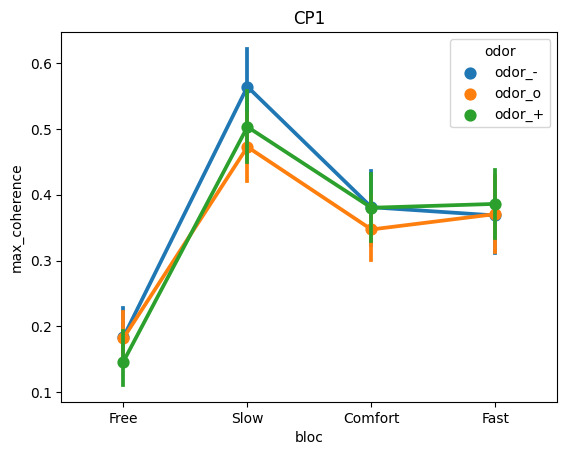

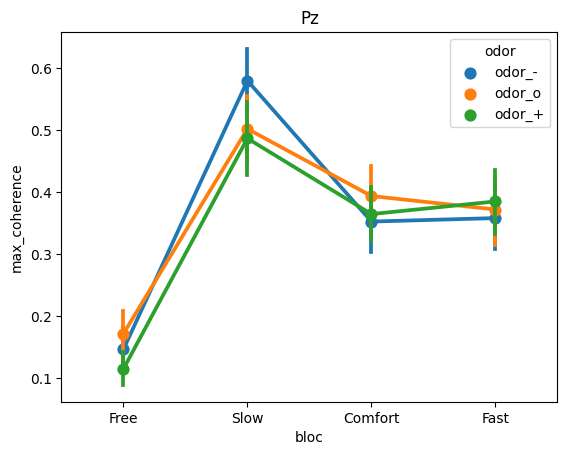

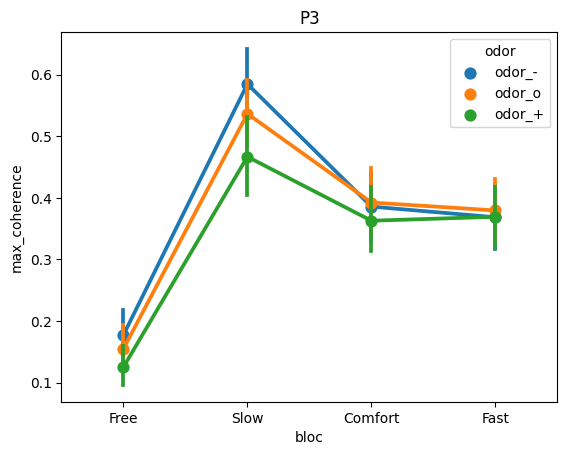

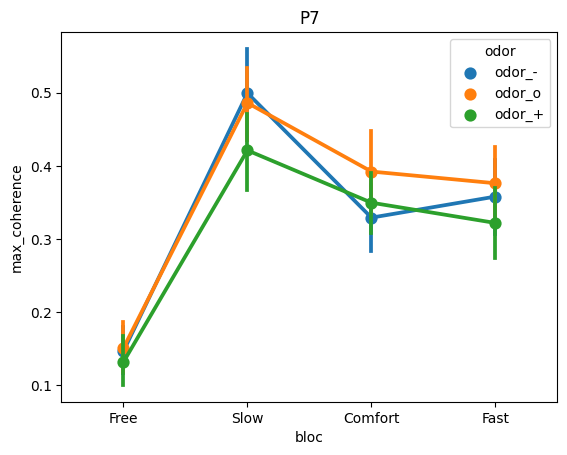

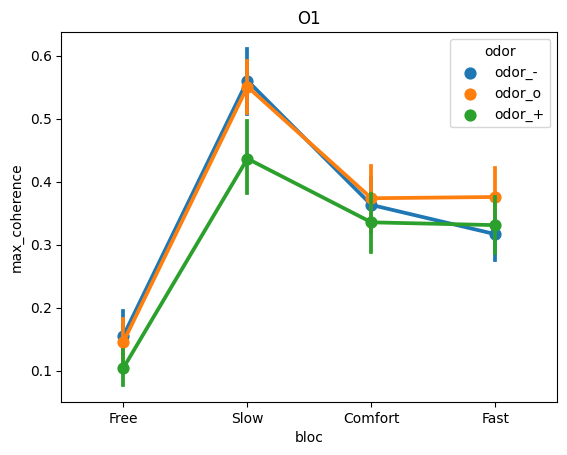

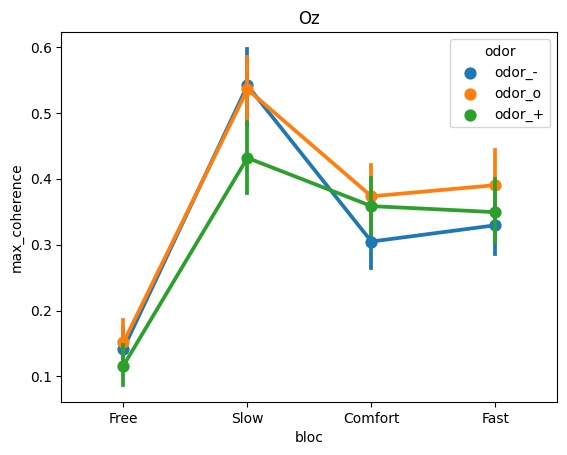

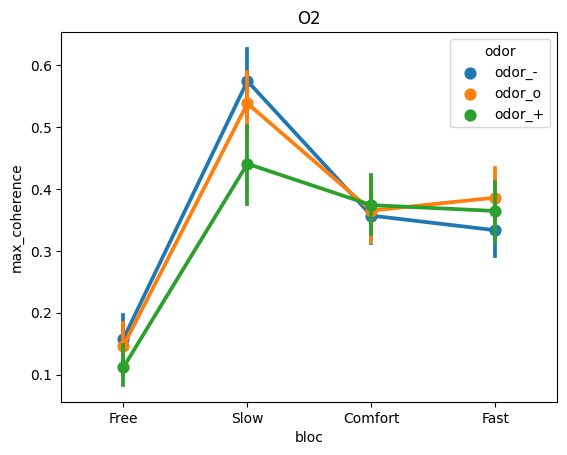

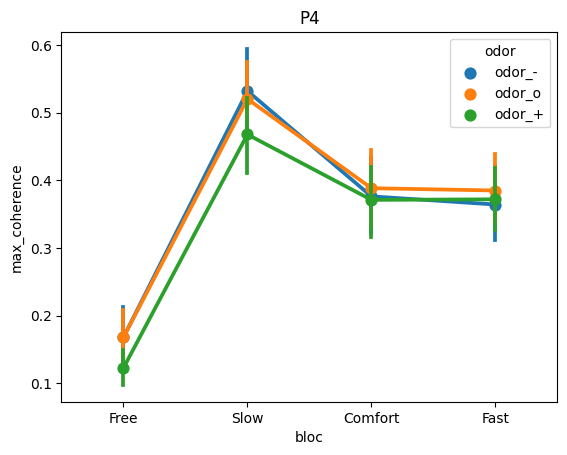

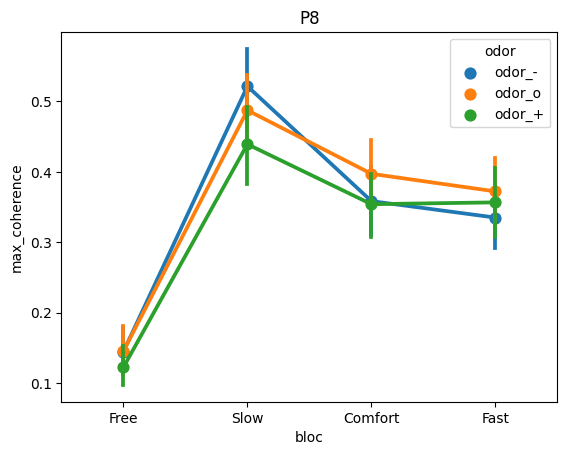

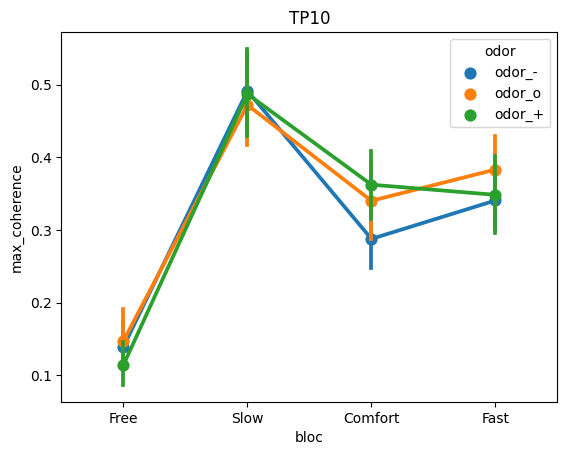

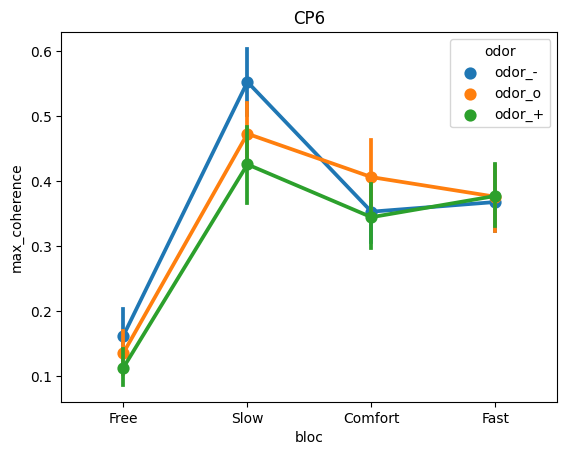

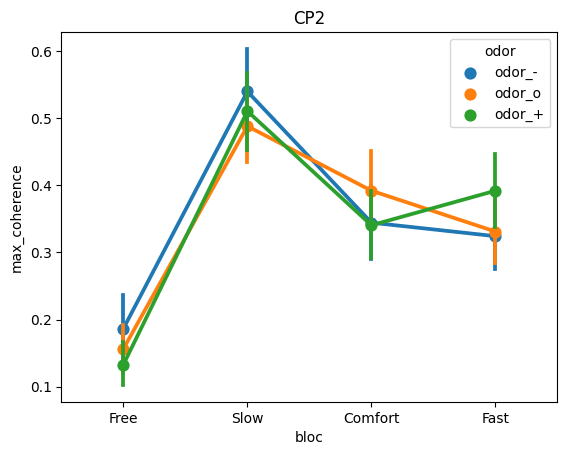

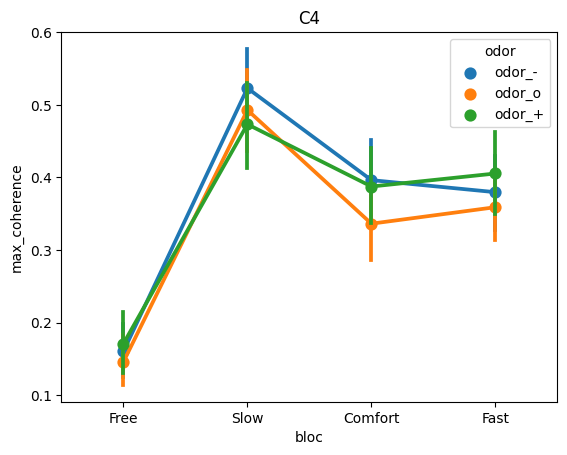

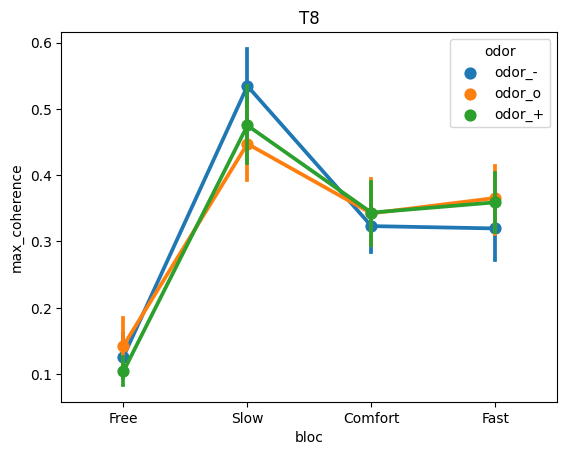

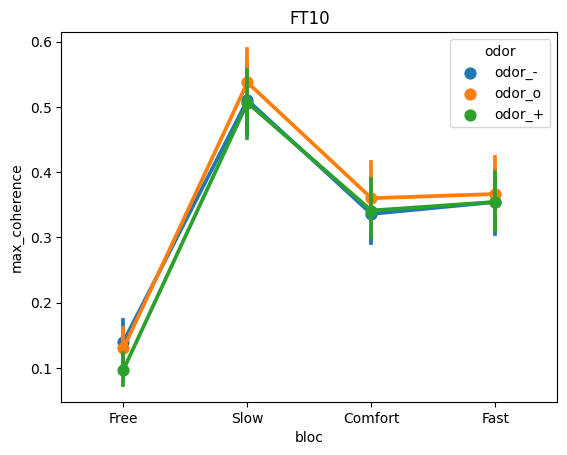

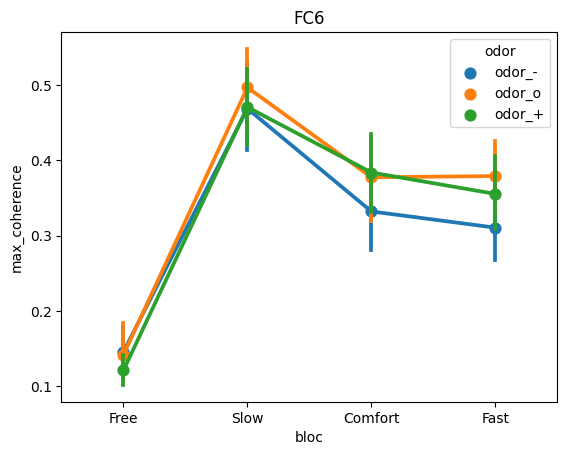

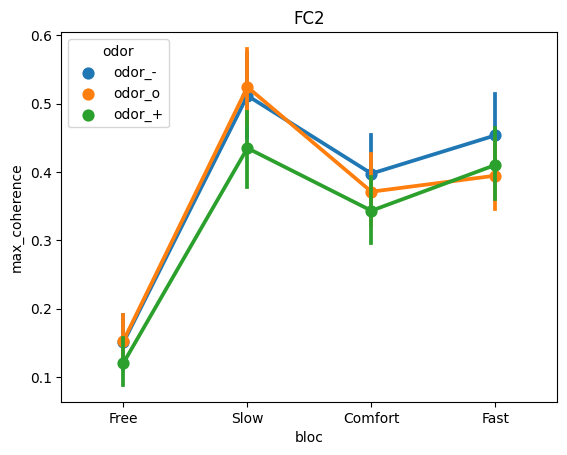

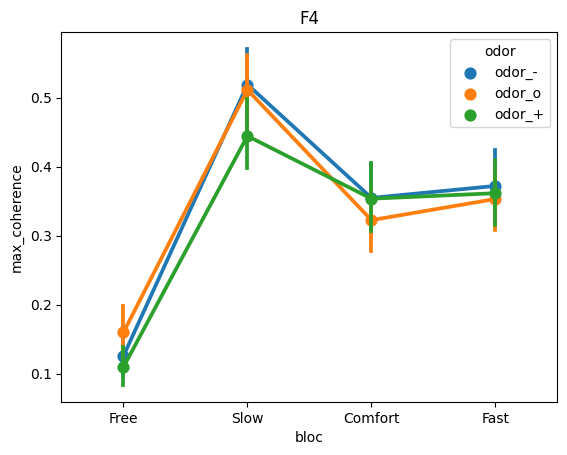

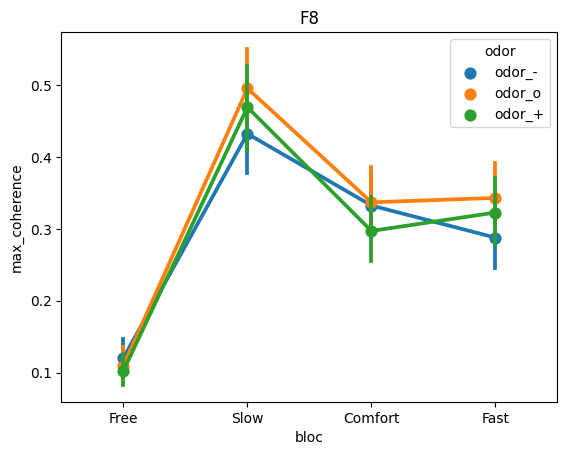

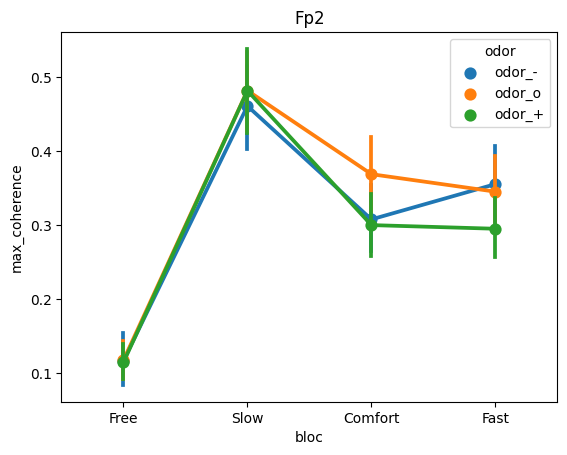

In [6]:
for chan in eeg_chans:
    df = coherence[coherence['chan'] == chan]
    fig, ax = plt.subplots()
    sns.pointplot(data = df, x = 'bloc', y = 'max_coherence', hue = 'odor', ax=ax)
    ax.set_title(chan)
    plt.show()

In [7]:
pos = get_pos()

SAVING


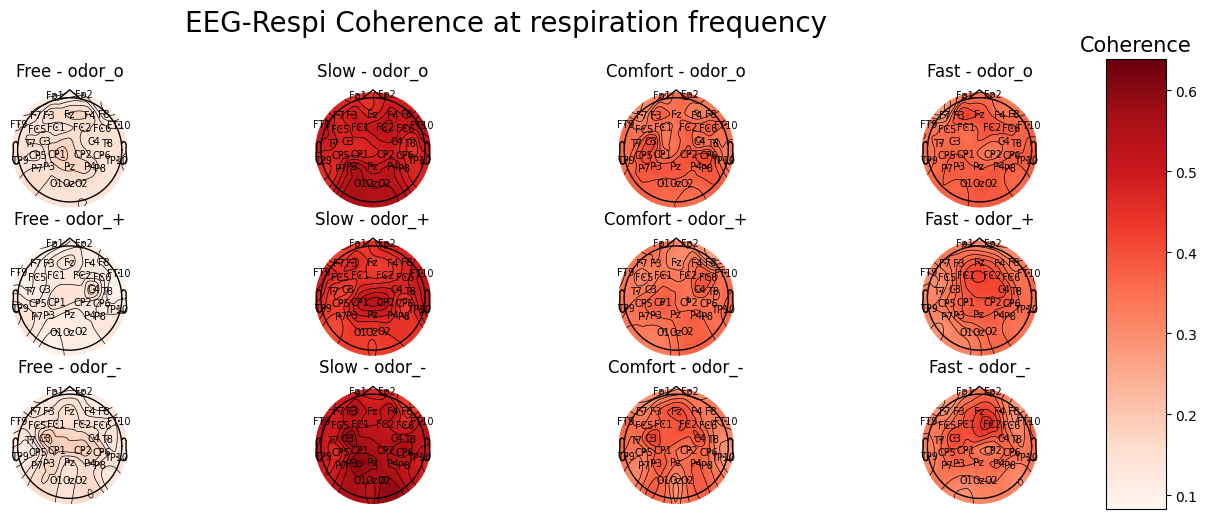

In [8]:
q_diff = 0.01

vmin = coherence.groupby(['bloc','odor','session','chan']).mean(numeric_only = True)['max_coherence'].quantile(q_diff)
vmax = coherence.groupby(['bloc','odor','session','chan']).mean(numeric_only = True)['max_coherence'].quantile(1 - q_diff)


fig, axs = plt.subplots(nrows = len(odeurs), ncols = len(blocs), figsize = (15,5))
fig.suptitle('EEG-Respi Coherence at respiration frequency', fontsize = 20, y = 1.1)
for c, bloc in enumerate(blocs):
    for r, odor in enumerate(odeurs) :
        ax = axs[r,c]
        topo_data = coherence[(coherence['bloc'] == bloc) & (coherence['odor'] == odor)].groupby('chan').mean(numeric_only = True)['max_coherence'].reindex(eeg_chans)
        im, cn = mne.viz.plot_topomap(data =topo_data.values , pos = pos, names = eeg_chans, axes = ax, show = False, vlim = (vmin,vmax))
        ax.set_title(f'{bloc} - {odor}')
        
ax_x_start = 0.9
ax_x_width = 0.04
ax_y_start = 0.1
ax_y_height = 0.9
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title('Coherence',fontsize=15)

file = f'../Figures/Coherence_at_resp/global/all_subjects.png'
if not os.path.isfile(file):
    print('SAVING')
    fig.savefig(file, bbox_inches = 'tight')
else:
    print('ALREADY SAVED')
    
fig.show()

In [9]:
for sub in subject_keys:
    
    coherence_sub = coherence[coherence['participant'] == sub]
    
    q_diff = 0.01

    vmin = coherence_sub.groupby(['bloc','odor','session','chan']).mean(numeric_only = True)['max_coherence'].quantile(q_diff)
    vmax = coherence_sub.groupby(['bloc','odor','session','chan']).mean(numeric_only = True)['max_coherence'].quantile(1 - q_diff)


    fig, axs = plt.subplots(nrows = len(odeurs), ncols = len(blocs), figsize = (15,5))
    fig.suptitle(f'EEG-Respi Coherence at respiration frequency - {sub}', fontsize = 20, y = 1.1)
    for c, bloc in enumerate(blocs):
        for r, odor in enumerate(odeurs) :
            ax = axs[r,c]
            topo_data = coherence_sub[(coherence_sub['bloc'] == bloc) & (coherence_sub['odor'] == odor)].groupby('chan').mean(numeric_only = True)['max_coherence'].reindex(eeg_chans)
            im, cn = mne.viz.plot_topomap(data =topo_data.values , pos = pos, names = eeg_chans, axes = ax, show = False, vlim = (vmin,vmax))
            ax.set_title(f'{bloc} - {odor}')

    ax_x_start = 0.9
    ax_x_width = 0.04
    ax_y_start = 0.1
    ax_y_height = 0.9
    cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
    clb = fig.colorbar(im, cax=cbar_ax)
    clb.ax.set_title('Coherence',fontsize=15)

    file = f'../Figures/Coherence_at_resp/by_subject/{sub}.png'
    if not os.path.isfile(file):
        print('SAVING')
        fig.savefig(file, bbox_inches = 'tight')
    else:
        print('ALREADY SAVED')

    plt.close()

SAVING
SAVING
SAVING
SAVING
SAVING
SAVING
SAVING
SAVING
SAVING
SAVING
SAVING
SAVING
SAVING
SAVING
SAVING
SAVING
SAVING
SAVING
SAVING
SAVING
SAVING
SAVING
SAVING
SAVING
SAVING
SAVING
SAVING
SAVING
SAVING
SAVING


In [10]:
# coherence_sig = None
# for run_key in run_keys:
#     participant, session = run_key.split('_')[0] , run_key.split('_')[1]
#     odeur = get_odor_from_session(run_key)
    
#     coherence_da = coherence_job.get(run_key)
#     coherence_da = coherence_da['coherence']
    
#     if coherence_sig is None:
#         coherence_sig = init_nan_da({'participant':subject_keys, 'odor':odeurs, 'bloc':coherence_da.coords['bloc'].values, 'trial':coherence_da.coords['trial'].values, 'chan':coherence_da.coords['chan'].values, 'freq':coherence_da.coords['freq'].values})
#     coherence_sig.loc[participant, odeur, :, :, :, :] = coherence_da.values

In [11]:
# coherence_sig

In [12]:
# coherence_sig_mean_trial = coherence_sig.sel(freq = slice(None,0.6)).mean('trial')

In [13]:
# coherence_sig_mean_trial.sel(chan = 'C3').plot.line(x = 'freq', hue = 'bloc', col = 'odor', row = 'participant')